In [1]:
!git clone https://github.com/yarathealmighty/dumps.git
!cd dumps/data
!git clone https://https://huggingface.co/datasets/yarathealmighty/dumps
!pip install datasets
!pip install huspacy
!pip install spacy_syllables
# not necessary, just prettier logging
!pip install tqdm
!pip install praw

fatal: destination path 'dumps' already exists and is not an empty directory.
fatal: destination path 'dumps' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 5.5 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import dumps.utils as utils
from collections import Counter

from tqdm import tqdm
import huspacy
from spacy_syllables import SpacySyllables

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
huspacy.download()
nlp_hu = huspacy.load()

['/usr/bin/python3', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


/usr/local/lib/python3.10/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'hu_core_news_lg' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
nlp_hu.add_pipe('syllables', after='tagger')
nlp_hu.pipe_names

['tok2vec',
 'senter',
 'tagger',
 'syllables',
 'morphologizer',
 'lookup_lemmatizer',
 'trainable_lemmatizer',
 'parser',
 'ner']

In [11]:
def get_qas(df, tokenize=False, debug_stopwords=False, debug_original=True):
    data = []

    for idx, row in tqdm(df.iterrows(), desc='Getting Question-Answer-Score trios', total=len(df)):
        question_text = row['text'].lower()

        # Tokenize the question if enabled
        tokenized_question = None
        if tokenize:
            doc_question = nlp_hu(question_text)
            tokenized_question = [token for token in doc_question if not token.is_stop] if not debug_stopwords else list(doc_question)

        # Process each answer in comments
        for comment in row['comments']:
            if contains_media(comment['body']):
                continue

            answer_text = comment['body'].lower()
            score = comment['ups']

            # Tokenize the answer if enabled
            tokenized_answer = None
            if tokenize:
                doc_answer = nlp_hu(answer_text)
                tokenized_answer = [token for token in doc_answer if not token.is_stop] if not debug_stopwords else list(doc_answer)

            # Append data for each processed comment
            if debug_original:
                if tokenize:
                    data.append((question_text, answer_text, score, tokenized_question, tokenized_answer))
                else:
                    data.append((question_text, answer_text, score))
            else:
                if tokenize:
                    data.append((tokenized_question, tokenized_answer, score))
                else:
                    data.append((question_text, answer_text, score))

    # Create DataFrame based on debug_original and tokenize flags
    if debug_original:
        if tokenize:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score', 'tokenized_question', 'tokenized_answer'])
        else:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])
    else:
        if tokenize:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])
        else:
            df_result = pd.DataFrame(data, columns=['question', 'answer', 'score'])

    return df_result


def contains_media(text):
    if re.search(r'(https?:\/\/.*\.(png|jpg|jpeg|gif|mp4|webm|avi|mov|wmv))', text):
        return True
    if re.search(r'(![gif]*)',text):
        return True
    return False

def after_clean(df):
    new_token_answers = []
    new_token_questions = []
    for row in tqdm(df.iterrows(), desc='Cleaning some stuff up', total=len(df)):
        tmp_a = [token[:-1] for token in row[1]['tokenized_answer'].split(' ') if token[:-1] != '']
        tmp_q = [token[:-1] for token in row[1]['tokenized_question'].split(' ') if token[:-1] != '']
        if tmp_a[0][0] == '[':
            tmp_a[0] = tmp_a[0][1:]
        if tmp_q[0][0] == '[':
            tmp_q[0] = tmp_q[0][1:]
        new_token_answers.append(tmp_a)
        new_token_questions.append(tmp_q)
    df['tokenized_answer'] = new_token_answers
    df['tokenized_question'] = new_token_questions
    return df

def get_common_words(df):

  # may need some better solution
  no_no_list = [',','.','?','!',':','*','"','(',')','[',']','{','}','-','','“','”','\\','/','\'','\n','<','>','_','^','˘','~','|','&','…']
  new_common_words = []
  jaccard_indices = []

  for row in tqdm(df.iterrows(), desc='Getting common words between questions and answers', total=len(df)):
    tok_a = row[1]['tokenized_answer']
    tok_q = row[1]['tokenized_question']
    c = Counter()
    for token in tok_a:
      c[token] += 1
    for token in tok_q:
      c[token] += 1
    common_words = [token.strip() for token in c if c[token] > 1 and token not in no_no_list and len(token) != 0]
    new_common_words.append(common_words)
    # metszet / a + b - metszet (összes)
    jaccard_indices.append(len(common_words)/(len(tok_a)+len(tok_q)-len(common_words)))
  df['common_words'] = new_common_words
  df['jaccard_index'] = jaccard_indices
  return df

# TODO check this out
def calculate_cosine_similarity(df):
    # Combine each question and answer as a pair in a new column
    df['combined_text'] = df['question'] + ' ' + df['answer']

    # Initialize the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform each question and answer separately
    tfidf_question = vectorizer.fit_transform(df['question'])
    tfidf_answer = vectorizer.transform(df['answer'])

    # Calculate cosine similarity for each pair
    cosine_similarities = [cosine_similarity(tfidf_question[i], tfidf_answer[i])[0][0] for i in tqdm(range(len(df)), desc='Calculating cosine similarity for each question - answer pair', total=len(df))]

    # Add results to the DataFrame
    df['cosine_similarity'] = cosine_similarities
    df = df.drop(columns=['combined_text'])

    return df

def flesch_kincaid(df):
  answer_flesch_kincaid_scores = []
  question_flesch_kincaid_scores = []

  for row in tqdm(df.iterrows(), desc='Calculating Flesch-Kincaid score for each question and answer', total=len(df)):
    doc_answer = nlp_hu(row[1]['answer'])
    doc_question = nlp_hu(row[1]['question'])

    answer_total_words = len(doc_answer)
    question_total_words = len(doc_question)

    answer_total_sentences = len(list(doc_answer.sents))
    question_total_sentences = len(list(doc_question.sents))

    answer_total_syllables = sum(token._.syllables_count for token in doc_answer if token._.syllables_count is not None)
    question_total_syllables = sum(token._.syllables_count for token in doc_question if token._.syllables_count is not None)

    # formula from wikipedia
    answer_flesch_kincaid_score = 206.835 - 1.015 * (answer_total_words / answer_total_sentences) - 84.6 * (answer_total_syllables / answer_total_words)
    question_flesch_kincaid_score = 206.835 - 1.015 * (question_total_words / question_total_sentences) - 84.6 * (question_total_syllables / question_total_words)

    answer_flesch_kincaid_scores.append(answer_flesch_kincaid_score)
    question_flesch_kincaid_scores.append(question_flesch_kincaid_score)

  df['flesch_kincaid_answer'] = answer_flesch_kincaid_scores
  df['flesch_kincaid_question'] = question_flesch_kincaid_scores
  return df

In [27]:
DEBUG = False

if DEBUG:
  # get dataset and load it in as pandas df
  # credit to Bazsalanszky for collecting the posts
  ds = load_dataset("Bazsalanszky/reddit_hu")
  df = ds['train'].to_pandas()
  df1 = df[df['subreddit']=='askhungary']
  df2 = df1[df1['is_video']==False]
  df3 = df2.drop(columns=['author_flair_text','is_video','subreddit','num_crossposts','subreddit_subscribers','url','treatment_tags','all_awardings','is_crosspostable','after'])
  df4 = df3[df3['comments'].notna()]

  # append titles and bodies
  text = []
  for row in df4.iterrows():
    row_text = row[1]['title'] + ' ' + row[1]['selftext']
    text.append(row_text)
  df4['text'] = text

  # leave only questions in (brute force '?' search)
  df5 = df4[df4['text'].str.contains('\?')]

  # very specific drop, print to see why
  df5 = df5[2:]

  df5 = df5.drop_duplicates(subset='title')

  # get question-answer-score trios from the posts and comments
  df = get_qas(df5,tokenize=True,debug_stopwords=False,debug_original=True)
  df = after_clean(df5)

  # normalize scores
  normalized = utils.normalize_scores(df,True)
  normalized.to_csv('big_qas.csv')
  df = normalized.dropna(subset=['score'])

  # TODO more elegant solution
  df = get_common_words(df)

  # cosine similartiy
  df = calculate_cosine_similarity(df)

  # readibility
  # needs a ton of time (at least 1-2 hours)
  df = flesch_kincaid(df)

  df.to_csv('big_qas.csv')

else:
  # quick load, less RAM
  ds = load_dataset("yarathealmighty/hurQA")
  normalized = ds['train'].to_pandas()
  df5 = normalized.drop(columns=['Unnamed: 0'])
  df = after_clean(df5)
  df = df.dropna(subset=['score'])

train.csv:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10505 [00:00<?, ? examples/s]

Cleaning some stuff up: 100%|██████████| 10505/10505 [00:02<00:00, 4459.46it/s]


Getting common words between questions and answers: 100%|██████████| 10505/10505 [00:01<00:00, 5334.30it/s]
<ipython-input-7-98281719996d>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['common_words'] = new_common_words
<ipython-input-7-98281719996d>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['jaccard_index'] = jaccard_indices


In [19]:
df

,question,answer,tokenized_question,tokenized_answer,score,common_words,jaccard_index,cosine_similarity,flesch_kincaid_answer,flesch_kincaid_question
0,mi történik a bölcsiben a nem alvó gyerekkel? ...,általában a legkisebb egyéni igény/probléma es...,"[történik, bölcsiben, alvó, gyerekkel, ?, kisf...","[legkisebb, egyéni, igény/probléma, esetén, ké...",1.000000,"[haza, történik, gyerekkel, sír, többi]",0.035714,0.040971,61.992981,61.421943
1,mi történik a bölcsiben a nem alvó gyerekkel? ...,a kislányom a bölcsijében sem engedték ki a gy...,"[történik, bölcsiben, alvó, gyerekkel, ?, kisf...","[kislányom, bölcsijében, engedték, gyerekeket,...",0.358491,"[oviban, bölcsiben, alvás, idő, 2, éves, gond,...",0.082192,0.143972,53.571750,61.421943
2,mi történik a bölcsiben a nem alvó gyerekkel? ...,"mondd meg sajnos, hogy erre nincs lehetőség, h...","[történik, bölcsiben, alvó, gyerekkel, ?, kisf...","[mondd, sajnos, ,, lehetőség, ,, elhozd, ., ma...",0.584906,"[történik, gyerekkel, sír, többi]",0.035088,0.029405,84.900000,61.421943
3,mi történik a bölcsiben a nem alvó gyerekkel? ...,wtf? nem mehet a gyerek játszani ha a többi al...,"[történik, bölcsiben, alvó, gyerekkel, ?, kisf...","[wtf, ?, mehet, gyerek, játszani, többi, alszi...",0.830189,"[többi, alszik, két, mások, oviban, éves, fog,...",0.081481,0.128293,91.199836,61.421943
4,mi történik a bölcsiben a nem alvó gyerekkel? ...,"en oviban nem aludtam, az óvónők és a dadus ir...","[történik, bölcsiben, alvó, gyerekkel, ?, kisf...","[en, oviban, aludtam, ,, óvónők, dadus, irtora...",0.594340,"[en, történik, gyerekkel, sír, többi]",0.035714,0.055409,61.110357,61.421943
...,...,...,...,...,...,...,...,...,...,...
10504,csak nekem iszonyatosan kínos a magyar nyelvű ...,egy amerikai államban valaki meg ezt írhatta:...,"[iszonyatosan, kínos, magyar, nyelvű, erotika,...","[amerikai, államban, írhatta, :, \n, szerintem...",0.000000,"[szerintem, erotikus, kínos, magyar, nyelvű, m...",0.060606,0.147198,55.176014,44.519293
10505,van itt olyan aki volt már pszichiátrián? ha ...,"ez egy automatikus válasz, mert a posztodhoz a...","[pszichiátrián, ?, mesélne, róla, ,, engem, ér...","[automatikus, válasz, ,, posztodhoz, mental, h...",0.000000,"[, érdemes, éves, chaten, -n, segítségre, szük...",0.043716,0.044131,43.215176,54.274102
10506,van itt olyan aki volt már pszichiátrián? ha ...,szia. egy nagyon súlyos pánikrohammal/szorongá...,"[pszichiátrián, ?, mesélne, róla, ,, engem, ér...","[szia, ., súlyos, pánikrohammal/szorongással, ...",1.000000,[bent],0.017241,0.004567,100.240667,54.274102
10507,van itt olyan aki volt már pszichiátrián? ha ...,egyaltalan nem bunkok es a nyiro egy eleg jo h...,"[pszichiátrián, ?, mesélne, róla, ,, engem, ér...","[egyaltalan, bunkok, es, nyiro, eleg, jo, hely...",0.000000,[jo],0.017544,0.007124,54.750870,54.274102


In [25]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tfidf_q = TfidfVectorizer()
tfidf_a = TfidfVectorizer()

X = df[['common_words', 'jaccard_index', 'cosine_similarity', 'flesch_kincaid_answer', 'flesch_kincaid_question']]
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# pred
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("Root Mean Squared Error:", rmse)

ValueError: empty vocabulary; perhaps the documents only contain stop words

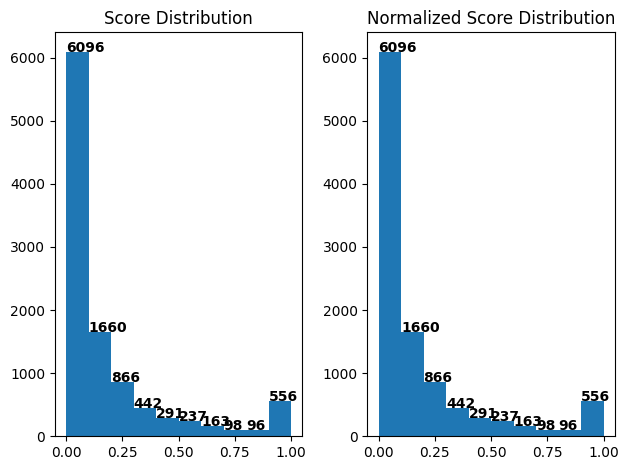

In [ ]:
# plot scores
Sfig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].set_title("Score Distribution")
axs[1].set_title("Normalized Score Distribution")

score_distribution = axs[0].hist(df['score'], bins=10)
normalized_score_distribution = axs[1].hist(normalized['score'], bins=10)

for distributions, ax in zip([score_distribution, normalized_score_distribution], axs):
    for j in range(10):
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

plt.show()

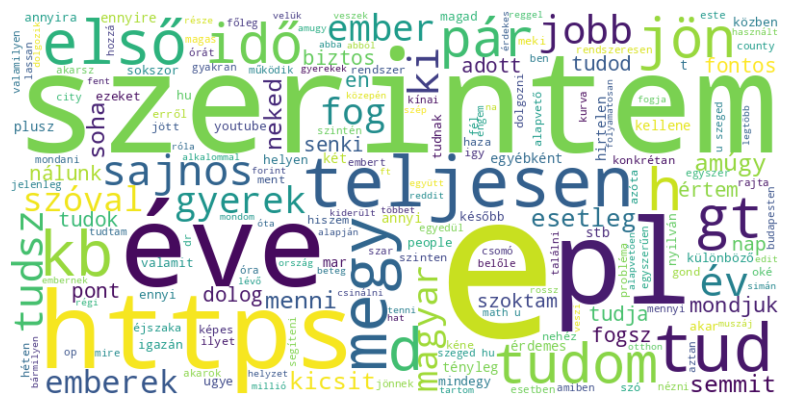

In [ ]:
# best answers wordcloud
idx = df.groupby('question')['score'].idxmax()
highest_scores_df = df5.loc[idx]

combined_answers = ' '.join(highest_scores_df['answer'].tolist())

doc = nlp_hu(combined_answers)
filtered_words = [token.text for token in doc if not token.is_stop and not token.is_punct and token.text != 'se' and token.text != 'e']

filtered_text = ' '.join(filtered_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

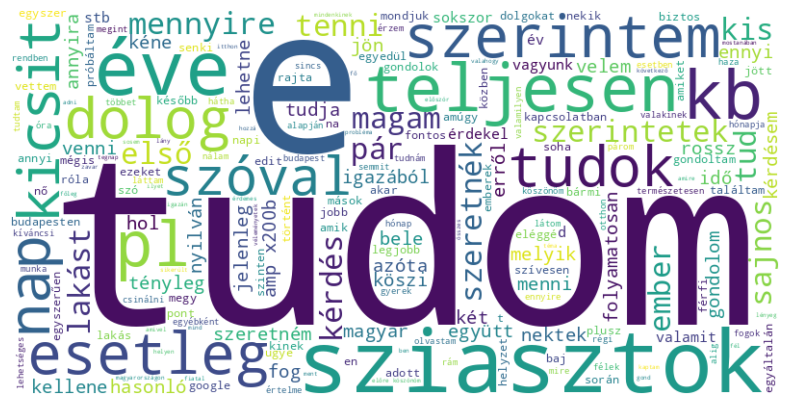

In [ ]:
# questions wordcloud
questions = []
prev = ''
for row in df.iterrows():
  if row[1]['question'] != prev:
    questions.append(row[1]['question'])
    prev = row[1]['question']

text = " ".join(q for q in questions)

doc = nlp_hu(text)
filtered_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and token.text != 'se' and token.text != 'e']

filtered_text = " ".join(filtered_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [18]:
from huggingface_hub import HfApi, HfFolder
import pandas as pd

# Your Hugging Face repo
repo_id = "yarathealmighty/hurQA"

# Path to save the dataframe locally before upload
df_path = "big_qas.csv"

# Upload the file to your Hugging Face dataset repo
api = HfApi()
api.upload_file(
    path_or_fileobj=df_path,
    path_in_repo="train.csv",
    repo_id=repo_id,
    repo_type="dataset"  # Specify this is a dataset repo
)

big_qas.csv:   0%|          | 0.00/22.3M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/yarathealmighty/hurQA/commit/f9219488101b02ddbd9fa2237d5c6a51befc1e63', commit_message='Upload train.csv with huggingface_hub', commit_description='', oid='f9219488101b02ddbd9fa2237d5c6a51befc1e63', pr_url=None, pr_revision=None, pr_num=None)